In [14]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [15]:
import sagemaker
import uuid

sagemaker_session = sagemaker.Session()
print('SageMaker version: ' + sagemaker.__version__)

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-cnn-cifar10'

role = sagemaker.get_execution_role()
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_path = 's3://{}/checkpoints/checkpoint-{}'.format(bucket, checkpoint_suffix)

print('Checkpointing Path: {}'.format(checkpoint_s3_path))

SageMaker version: 2.106.0
Checkpointing Path: s3://sagemaker-us-east-1-551329315830/checkpoints/checkpoint-7e74740e


In [16]:
electricity_df = pd.read_csv("tft/outputs/data/electricity/hourly_electricity.csv")

electricity_df['hours_from_start'] = electricity_df['hours_from_start'].astype(int)
electricity_df['power_usage'] = electricity_df['power_usage'].astype(float)
electricity_df['hour'] = electricity_df['hour'].astype(int)
electricity_df['day_of_week'] = electricity_df['day_of_week'].astype(int)
electricity_df['categorical_id'] = electricity_df['categorical_id'].astype(str)

In [4]:
import os
import json
def save_local_and_upload_s3(data_df, sagemaker_session, bucket, dir_name = "timeseries_data", data_filename = "data"):
    #create data directory if not exist
    if os.path.isdir(dir_name):
        print("Checkpointing directory {} exists".format(dir_name))
    else:
        print("Creating Checkpointing directory {}".format(dir_name))
        os.makedirs(dir_name)

    data_df.to_parquet('{}/{}.parquet'.format(dir_name, data_filename))   
    print("saved raw data to {}/{}.parquet".format(dir_name, data_filename))
    
    return sagemaker_session.upload_data(path=dir_name, bucket=bucket, key_prefix='data/{}'.format(dir_name))



def metadata_json_upload_s3(training_metadata, sagemaker_session, bucket, dir_name = "timeseries_data", metadata_filename = "data_metadata"):
    #create data directory if not exist
    if os.path.isdir(dir_name):
        print("Checkpointing directory {} exists".format(dir_name))
    else:
        print("Creating Checkpointing directory {}".format(dir_name))
        os.makedirs(dir_name)
    
    with open('{}/{}.json'.format(dir_name, metadata_filename), 'w') as fp:
        json.dump(training_metadata, fp)
        print("saved metadata to {}/{}.json".format(dir_name, metadata_filename))
    
    return sagemaker_session.upload_data(path=dir_name, bucket=bucket, key_prefix='data/{}'.format(dir_name))


In [5]:
# max_prediction_length = 24
# max_encoder_length = 24 * 7
# num_epochs = 100
# early_stopping_patience = 5
# multiprocessing_workers = 5


# dropout_rate = 0.1
# hidden_layer_size = 160
# learning_rate = 0.001
# minibatch_size = 64
# max_gradient_norm = 0.01
# num_heads = 4
# stack_size =  1

In [6]:
import pandas as pd 

inputs = save_local_and_upload_s3(electricity_df, sagemaker_session, bucket,
                                  dir_name = "timeseries_data/electricity",
                                  data_filename="electricity_training_data")
inputs

Checkpointing directory timeseries_data/electricity exists
saved raw data to timeseries_data/electricity/electricity_training_data.parquet


's3://sagemaker-us-east-1-551329315830/data/timeseries_data/electricity'

In [17]:
max_prediction_length = 24
max_encoder_length = 24 * 7


training_metadata = {}
training_metadata['time_idx'] = "hours_from_start"
training_metadata['target'] = "power_usage"
training_metadata['group_ids'] = ["categorical_id"]
training_metadata['min_encoder_length'] = max_encoder_length      # keep encoder length long (as it is in the validation set)
training_metadata['max_encoder_length'] = max_encoder_length
training_metadata['min_prediction_length'] = 1      
training_metadata['max_prediction_length'] = max_prediction_length
training_metadata['static_categoricals'] = ["categorical_id"]
training_metadata['static_reals'] = []
training_metadata['time_varying_known_categoricals'] = []
training_metadata['variable_groups'] = {}
training_metadata['time_varying_known_reals'] = ["hours_from_start", "day_of_week", "hour"]
training_metadata['time_varying_unknown_categoricals'] = []
training_metadata['time_varying_unknown_reals'] = []
training_metadata['target_normalizer'] = {
                            "normalized_groups": ["categorical_id"],
                            "normalization_transformation": 'softplus'
                        }
training_metadata['add_relative_time_idx'] = True
training_metadata['add_target_scales'] = True
training_metadata['add_encoder_length'] = True
training_metadata['allow_missing_timesteps'] = True

training_metadata['training_cutoff'] = int(electricity_df[training_metadata['time_idx']].max() - max_prediction_length)
# training_metadata['training_cutoff'] = int(electricity_df[training_metadata['time_idx']].max())

# upload metadata
metadata_json_upload_s3(training_metadata, sagemaker_session, bucket, 
                                    dir_name = "timeseries_data/electricity",
                                    metadata_filename="electricity_metadata")

Checkpointing directory timeseries_data/electricity exists
saved metadata to timeseries_data/electricity/electricity_metadata.json


's3://sagemaker-us-east-1-551329315830/data/timeseries_data/electricity'

In [8]:
hyperparameters = {
        'data-filename': "electricity_training_data.parquet",
        'metadata-filename': "electricity_metadata.json",
    
        'max-prediction-length' : max_prediction_length,
        'max-encoder-length' : max_encoder_length,
#         'num-epochs' : 2,
        'num-epochs' : 100,

        'early-stopping-patience' : 5,
        'multiprocessing-workers' : 5,


        'dropout-rate' : 0.1,
        'hidden-layer-size' : 160,
        'learning-rate' : 0.001,
        'minibatch-size' : 64,
        'max-gradient-norm' : 0.01,
        'num-heads' : 4
    
    }


In [9]:
use_spot_instances = True
max_run=36000      # in seconds, after this, job will be terminated
max_wait = 10 * max_run if use_spot_instances else None
local_image_name = 'pytorch-tft-container-test'

In [ ]:
from sagemaker.pytorch import PyTorch
from sagemaker.estimator import Estimator
from sagemaker.debugger import TensorBoardOutputConfig


tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path='s3://sagemaker-us-east-1-551329315830/tensorboard',
    container_local_output_path='/lightning_logs'
)

spot_estimator  = PyTorch(entry_point='../TFT_docker/TFT.py',
                            dependencies=['../TFT_docker/requirements.txt'],
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
#                             instance_type='local',
                            instance_type='ml.p3.2xlarge',
#                             instance_type='ml.p2.xlarge',
                            base_job_name='tft-pytorch-spot-1',
                            hyperparameters=hyperparameters,
                            checkpoint_s3_uri=checkpoint_s3_path,
                            debugger_hook_config=False,
                            input_mode = 'File',
                            use_spot_instances=use_spot_instances,
                            max_run=max_run,
                            max_wait=max_wait,
                            tensorboard_output_config=tensorboard_output_config
                           )

spot_estimator.fit(
                inputs,
                logs = 'All'
            )

2022-09-01 13:55:04 Starting - Starting the training job...ProfilerReport-1662040504: InProgress
...
2022-09-01 13:55:35 Starting - Preparing the instances for training......
2022-09-01 13:57:01 Downloading - Downloading input data...
2022-09-01 13:57:21 Training - Downloading the training image...........loss=19.9, v_num=0, train_loss_step=8.330]#015Epoch 0:   9%|▉         | 3102/33371 [08:46<1:25:33,  5.90it/s, loss=19.9, v_num=0, train_loss_step=8.330]#015Epoch 0:   9%|▉         | 3102/33371 [08:46<1:25:33,  5.90it/s, loss=19.5, v_num=0, train_loss_step=9.840]#015Epoch 0:   9%|▉         | 3103/33371 [08:46<1:25:33,  5.90it/s, loss=19.5, v_num=0, train_loss_step=9.840]#015Epoch 0:   9%|▉         | 3103/33371 [08:46<1:25:33,  5.90it/s, loss=21.2, v_num=0, train_loss_step=57.80]#015Epoch 0:   9%|▉         | 3104/33371 [08:46<1:25:33,  5.90it/s, loss=21.2, v_num=0, train_loss_step=57.80]#015Epoch 0:   9%|▉         | 3104/33371 [08:46<1:25:33,  5.90it/s, loss=18.4, v_num=0, train_loss_st

 0:  10%|▉         | 3177/33371 [08:58<1:25:20,  5.90it/s, loss=21, v_num=0, train_loss_step=10.60]#015Epoch 0:  10%|▉         | 3177/33371 [08:58<1:25:20,  5.90it/s, loss=20.7, v_num=0, train_loss_step=13.70]#015Epoch 0:  10%|▉         | 3178/33371 [08:58<1:25:20,  5.90it/s, loss=20.7, v_num=0, train_loss_step=13.70]#015Epoch 0:  10%|▉         | 3178/33371 [08:58<1:25:20,  5.90it/s, loss=21, v_num=0, train_loss_step=15.70]  #015Epoch 0:  10%|▉         | 3179/33371 [08:59<1:25:19,  5.90it/s, loss=21, v_num=0, train_loss_step=15.70]#015Epoch 0:  10%|▉         | 3179/33371 [08:59<1:25:19,  5.90it/s, loss=21.2, v_num=0, train_loss_step=19.70]#015Epoch 0:  10%|▉         | 3180/33371 [08:59<1:25:19,  5.90it/s, loss=21.2, v_num=0, train_loss_step=19.70]#015Epoch 0:  10%|▉         | 3180/33371 [08:59<1:25:19,  5.90it/s, loss=21.6, v_num=0, train_loss_step=18.80]#015Epoch 0:  10%|▉         | 3181/33371 [08:59<1:25:19,  5.90it/s, loss=21.6, v_num=0, train_loss_step=18.80]#015Epoch 0:  10%|▉    

03,  5.90it/s, loss=19.1, v_num=0, train_loss_step=13.40]#015Epoch 0:  10%|▉         | 3252/33371 [09:11<1:25:03,  5.90it/s, loss=18.7, v_num=0, train_loss_step=8.980]#015Epoch 0:  10%|▉         | 3253/33371 [09:11<1:25:03,  5.90it/s, loss=18.7, v_num=0, train_loss_step=8.980]#015Epoch 0:  10%|▉         | 3253/33371 [09:11<1:25:03,  5.90it/s, loss=18.3, v_num=0, train_loss_step=16.30]#015Epoch 0:  10%|▉         | 3254/33371 [09:11<1:25:03,  5.90it/s, loss=18.3, v_num=0, train_loss_step=16.30]#015Epoch 0:  10%|▉         | 3254/33371 [09:11<1:25:03,  5.90it/s, loss=19.3, v_num=0, train_loss_step=39.20]#015Epoch 0:  10%|▉         | 3255/33371 [09:11<1:25:03,  5.90it/s, loss=19.3, v_num=0, train_loss_step=39.20]#015Epoch 0:  10%|▉         | 3255/33371 [09:11<1:25:03,  5.90it/s, loss=20.8, v_num=0, train_loss_step=39.70]#015Epoch 0:  10%|▉         | 3256/33371 [09:11<1:25:02,  5.90it/s, loss=20.8, v_num=0, train_loss_step=39.70]#015Epoch 0:  10%|▉         | 3256/33371 [09:11<1:25:02,  5.90i

oss_step=7.640]#015Epoch 0:  10%|▉         | 3327/33371 [09:23<1:24:49,  5.90it/s, loss=20.1, v_num=0, train_loss_step=15.00]#015Epoch 0:  10%|▉         | 3328/33371 [09:23<1:24:49,  5.90it/s, loss=20.1, v_num=0, train_loss_step=15.00]#015Epoch 0:  10%|▉         | 3328/33371 [09:23<1:24:49,  5.90it/s, loss=20.2, v_num=0, train_loss_step=16.00]#015Epoch 0:  10%|▉         | 3329/33371 [09:23<1:24:49,  5.90it/s, loss=20.2, v_num=0, train_loss_step=16.00]#015Epoch 0:  10%|▉         | 3329/33371 [09:23<1:24:49,  5.90it/s, loss=21.1, v_num=0, train_loss_step=25.90]#015Epoch 0:  10%|▉         | 3330/33371 [09:24<1:24:49,  5.90it/s, loss=21.1, v_num=0, train_loss_step=25.90]#015Epoch 0:  10%|▉         | 3330/33371 [09:24<1:24:49,  5.90it/s, loss=21.2, v_num=0, train_loss_step=16.80]#015Epoch 0:  10%|▉         | 3331/33371 [09:24<1:24:49,  5.90it/s, loss=21.2, v_num=0, train_loss_step=16.80]#015Epoch 0:  10%|▉         | 3331/33371 [09:24<1:24:49,  5.90it/s, loss=22.2, v_num=0, train_loss_step=3

71 [09:37<1:24:45,  5.89it/s, loss=23.7, v_num=0, train_loss_step=13.30]#015Epoch 0:  10%|█         | 3403/33371 [09:37<1:24:45,  5.89it/s, loss=23.7, v_num=0, train_loss_step=13.30]#015Epoch 0:  10%|█         | 3403/33371 [09:37<1:24:45,  5.89it/s, loss=23.8, v_num=0, train_loss_step=13.80]#015Epoch 0:  10%|█         | 3404/33371 [09:37<1:24:45,  5.89it/s, loss=23.8, v_num=0, train_loss_step=13.80]#015Epoch 0:  10%|█         | 3404/33371 [09:37<1:24:45,  5.89it/s, loss=21.2, v_num=0, train_loss_step=14.70]#015Epoch 0:  10%|█         | 3405/33371 [09:37<1:24:45,  5.89it/s, loss=21.2, v_num=0, train_loss_step=14.70]#015Epoch 0:  10%|█         | 3405/33371 [09:37<1:24:45,  5.89it/s, loss=21.1, v_num=0, train_loss_step=13.50]#015Epoch 0:  10%|█         | 3406/33371 [09:37<1:24:44,  5.89it/s, loss=21.1, v_num=0, train_loss_step=13.50]#015Epoch 0:  10%|█         | 3406/33371 [09:37<1:24:44,  5.89it/s, loss=21.2, v_num=0, train_loss_step=11.20]#015Epoch 0:  10%|█         | 3407/33371 [09:38<

7, v_num=0, train_loss_step=26.70]#015Epoch 0:  10%|█         | 3478/33371 [09:50<1:24:32,  5.89it/s, loss=18.7, v_num=0, train_loss_step=26.70]#015Epoch 0:  10%|█         | 3478/33371 [09:50<1:24:32,  5.89it/s, loss=17.9, v_num=0, train_loss_step=11.00]#015Epoch 0:  10%|█         | 3479/33371 [09:50<1:24:32,  5.89it/s, loss=17.9, v_num=0, train_loss_step=11.00]#015Epoch 0:  10%|█         | 3479/33371 [09:50<1:24:32,  5.89it/s, loss=17.9, v_num=0, train_loss_step=15.00]#015Epoch 0:  10%|█         | 3480/33371 [09:50<1:24:32,  5.89it/s, loss=17.9, v_num=0, train_loss_step=15.00]#015Epoch 0:  10%|█         | 3480/33371 [09:50<1:24:32,  5.89it/s, loss=16, v_num=0, train_loss_step=20.30]  #015Epoch 0:  10%|█         | 3481/33371 [09:50<1:24:31,  5.89it/s, loss=16, v_num=0, train_loss_step=20.30]#015Epoch 0:  10%|█         | 3481/33371 [09:50<1:24:31,  5.89it/s, loss=18, v_num=0, train_loss_step=57.80]#015Epoch 0:  10%|█         | 3482/33371 [09:50<1:24:31,  5.89it/s, loss=18, v_num=0, trai

       | 3553/33371 [10:02<1:24:20,  5.89it/s, loss=20.9, v_num=0, train_loss_step=45.10]#015Epoch 0:  11%|█         | 3553/33371 [10:02<1:24:20,  5.89it/s, loss=19, v_num=0, train_loss_step=9.880]  #015Epoch 0:  11%|█         | 3554/33371 [10:03<1:24:19,  5.89it/s, loss=19, v_num=0, train_loss_step=9.880]#015Epoch 0:  11%|█         | 3554/33371 [10:03<1:24:20,  5.89it/s, loss=19.1, v_num=0, train_loss_step=13.50]#015Epoch 0:  11%|█         | 3555/33371 [10:03<1:24:19,  5.89it/s, loss=19.1, v_num=0, train_loss_step=13.50]#015Epoch 0:  11%|█         | 3555/33371 [10:03<1:24:19,  5.89it/s, loss=19.2, v_num=0, train_loss_step=24.60]#015Epoch 0:  11%|█         | 3556/33371 [10:03<1:24:19,  5.89it/s, loss=19.2, v_num=0, train_loss_step=24.60]#015Epoch 0:  11%|█         | 3556/33371 [10:03<1:24:19,  5.89it/s, loss=19.4, v_num=0, train_loss_step=12.80]#015Epoch 0:  11%|█         | 3557/33371 [10:03<1:24:19,  5.89it/s, loss=19.4, v_num=0, train_loss_step=12.80]#015Epoch 0:  11%|█         | 355

v_num=0, train_loss_step=9.620]#015Epoch 0:  11%|█         | 3628/33371 [10:15<1:24:07,  5.89it/s, loss=21.2, v_num=0, train_loss_step=71.20]#015Epoch 0:  11%|█         | 3629/33371 [10:15<1:24:07,  5.89it/s, loss=21.2, v_num=0, train_loss_step=71.20]#015Epoch 0:  11%|█         | 3629/33371 [10:15<1:24:07,  5.89it/s, loss=20.2, v_num=0, train_loss_step=16.20]#015Epoch 0:  11%|█         | 3630/33371 [10:16<1:24:07,  5.89it/s, loss=20.2, v_num=0, train_loss_step=16.20]#015Epoch 0:  11%|█         | 3630/33371 [10:16<1:24:07,  5.89it/s, loss=21.5, v_num=0, train_loss_step=40.80]#015Epoch 0:  11%|█         | 3631/33371 [10:16<1:24:07,  5.89it/s, loss=21.5, v_num=0, train_loss_step=40.80]#015Epoch 0:  11%|█         | 3631/33371 [10:16<1:24:07,  5.89it/s, loss=21.5, v_num=0, train_loss_step=10.70]#015Epoch 0:  11%|█         | 3632/33371 [10:16<1:24:07,  5.89it/s, loss=21.5, v_num=0, train_loss_step=10.70]#015Epoch 0:  11%|█         | 3632/33371 [10:16<1:24:07,  5.89it/s, loss=21.7, v_num=0, t

%|█         | 3703/33371 [10:29<1:23:59,  5.89it/s, loss=19.8, v_num=0, train_loss_step=11.60]#015Epoch 0:  11%|█         | 3704/33371 [10:29<1:23:59,  5.89it/s, loss=19.8, v_num=0, train_loss_step=11.60]#015Epoch 0:  11%|█         | 3704/33371 [10:29<1:23:59,  5.89it/s, loss=22.1, v_num=0, train_loss_step=89.50]#015Epoch 0:  11%|█         | 3705/33371 [10:29<1:23:59,  5.89it/s, loss=22.1, v_num=0, train_loss_step=89.50]#015Epoch 0:  11%|█         | 3705/33371 [10:29<1:23:59,  5.89it/s, loss=23.3, v_num=0, train_loss_step=34.80]#015Epoch 0:  11%|█         | 3706/33371 [10:29<1:23:59,  5.89it/s, loss=23.3, v_num=0, train_loss_step=34.80]#015Epoch 0:  11%|█         | 3706/33371 [10:29<1:23:59,  5.89it/s, loss=23.1, v_num=0, train_loss_step=11.20]#015Epoch 0:  11%|█         | 3707/33371 [10:29<1:23:59,  5.89it/s, loss=23.1, v_num=0, train_loss_step=11.20]#015Epoch 0:  11%|█         | 3707/33371 [10:29<1:23:59,  5.89it/s, loss=21.4, v_num=0, train_loss_step=9.460]#015Epoch 0:  11%|█       

rain_loss_step=12.00]#015Epoch 0:  11%|█▏        | 3778/33371 [10:41<1:23:45,  5.89it/s, loss=16.9, v_num=0, train_loss_step=9.760]#015Epoch 0:  11%|█▏        | 3779/33371 [10:41<1:23:46,  5.89it/s, loss=16.9, v_num=0, train_loss_step=9.760]#015Epoch 0:  11%|█▏        | 3779/33371 [10:41<1:23:46,  5.89it/s, loss=17, v_num=0, train_loss_step=12.70]  #015Epoch 0:  11%|█▏        | 3780/33371 [10:42<1:23:45,  5.89it/s, loss=17, v_num=0, train_loss_step=12.70]#015Epoch 0:  11%|█▏        | 3780/33371 [10:42<1:23:45,  5.89it/s, loss=17.1, v_num=0, train_loss_step=13.70]#015Epoch 0:  11%|█▏        | 3781/33371 [10:42<1:23:45,  5.89it/s, loss=17.1, v_num=0, train_loss_step=13.70]#015Epoch 0:  11%|█▏        | 3781/33371 [10:42<1:23:45,  5.89it/s, loss=17.1, v_num=0, train_loss_step=11.20]#015Epoch 0:  11%|█▏        | 3782/33371 [10:42<1:23:45,  5.89it/s, loss=17.1, v_num=0, train_loss_step=11.20]#015Epoch 0:  11%|█▏        | 3782/33371 [10:42<1:23:45,  5.89it/s, loss=17.2, v_num=0, train_loss_st

 loss=16, v_num=0, train_loss_step=10.80]#015Epoch 0:  12%|█▏        | 3852/33371 [10:54<1:23:33,  5.89it/s, loss=16, v_num=0, train_loss_step=11.60]#015Epoch 0:  12%|█▏        | 3853/33371 [10:54<1:23:32,  5.89it/s, loss=16, v_num=0, train_loss_step=11.60]#015Epoch 0:  12%|█▏        | 3853/33371 [10:54<1:23:32,  5.89it/s, loss=16.2, v_num=0, train_loss_step=14.90]#015Epoch 0:  12%|█▏        | 3854/33371 [10:54<1:23:32,  5.89it/s, loss=16.2, v_num=0, train_loss_step=14.90]#015Epoch 0:  12%|█▏        | 3854/33371 [10:54<1:23:32,  5.89it/s, loss=16.3, v_num=0, train_loss_step=11.50]#015Epoch 0:  12%|█▏        | 3855/33371 [10:54<1:23:32,  5.89it/s, loss=16.3, v_num=0, train_loss_step=11.50]#015Epoch 0:  12%|█▏        | 3855/33371 [10:54<1:23:32,  5.89it/s, loss=16.4, v_num=0, train_loss_step=12.00]#015Epoch 0:  12%|█▏        | 3856/33371 [10:54<1:23:32,  5.89it/s, loss=16.4, v_num=0, train_loss_step=12.00]#015Epoch 0:  12%|█▏        | 3856/33371 [10:54<1:23:32,  5.89it/s, loss=16.2, v_nu

<1:23:19,  5.89it/s, loss=20.4, v_num=0, train_loss_step=10.40]#015Epoch 0:  12%|█▏        | 3926/33371 [11:06<1:23:19,  5.89it/s, loss=20.3, v_num=0, train_loss_step=10.80]#015Epoch 0:  12%|█▏        | 3927/33371 [11:06<1:23:19,  5.89it/s, loss=20.3, v_num=0, train_loss_step=10.80]#015Epoch 0:  12%|█▏        | 3927/33371 [11:06<1:23:19,  5.89it/s, loss=18.6, v_num=0, train_loss_step=9.090]#015Epoch 0:  12%|█▏        | 3928/33371 [11:06<1:23:19,  5.89it/s, loss=18.6, v_num=0, train_loss_step=9.090]#015Epoch 0:  12%|█▏        | 3928/33371 [11:06<1:23:19,  5.89it/s, loss=18.5, v_num=0, train_loss_step=8.970]#015Epoch 0:  12%|█▏        | 3929/33371 [11:07<1:23:19,  5.89it/s, loss=18.5, v_num=0, train_loss_step=8.970]#015Epoch 0:  12%|█▏        | 3929/33371 [11:07<1:23:19,  5.89it/s, loss=19.4, v_num=0, train_loss_step=33.90]#015Epoch 0:  12%|█▏        | 3930/33371 [11:07<1:23:19,  5.89it/s, loss=19.4, v_num=0, train_loss_step=33.90]#015Epoch 0:  12%|█▏        | 3930/33371 [11:07<1:23:19, 

     | 4000/33371 [11:19<1:23:06,  5.89it/s, loss=19.7, v_num=0, train_loss_step=26.20]#015Epoch 0:  12%|█▏        | 4000/33371 [11:19<1:23:06,  5.89it/s, loss=20.2, v_num=0, train_loss_step=22.30]#015Epoch 0:  12%|█▏        | 4001/33371 [11:19<1:23:06,  5.89it/s, loss=20.2, v_num=0, train_loss_step=22.30]#015Epoch 0:  12%|█▏        | 4001/33371 [11:19<1:23:06,  5.89it/s, loss=20.2, v_num=0, train_loss_step=9.620]#015Epoch 0:  12%|█▏        | 4002/33371 [11:19<1:23:06,  5.89it/s, loss=20.2, v_num=0, train_loss_step=9.620]#015Epoch 0:  12%|█▏        | 4002/33371 [11:19<1:23:06,  5.89it/s, loss=18.2, v_num=0, train_loss_step=41.40]#015Epoch 0:  12%|█▏        | 4003/33371 [11:19<1:23:06,  5.89it/s, loss=18.2, v_num=0, train_loss_step=41.40]#015Epoch 0:  12%|█▏        | 4003/33371 [11:19<1:23:06,  5.89it/s, loss=18.6, v_num=0, train_loss_step=35.30]#015Epoch 0:  12%|█▏        | 4004/33371 [11:19<1:23:06,  5.89it/s, loss=18.6, v_num=0, train_loss_step=35.30]#015Epoch 0:  12%|█▏        | 400

ch 0:  12%|█▏        | 4074/33371 [11:32<1:22:56,  5.89it/s, loss=16, v_num=0, train_loss_step=10.60]#015Epoch 0:  12%|█▏        | 4074/33371 [11:32<1:22:56,  5.89it/s, loss=16.7, v_num=0, train_loss_step=32.60]#015Epoch 0:  12%|█▏        | 4075/33371 [11:32<1:22:56,  5.89it/s, loss=16.7, v_num=0, train_loss_step=32.60]#015Epoch 0:  12%|█▏        | 4075/33371 [11:32<1:22:56,  5.89it/s, loss=16.8, v_num=0, train_loss_step=13.50]#015Epoch 0:  12%|█▏        | 4076/33371 [11:32<1:22:56,  5.89it/s, loss=16.8, v_num=0, train_loss_step=13.50]#015Epoch 0:  12%|█▏        | 4076/33371 [11:32<1:22:56,  5.89it/s, loss=16.6, v_num=0, train_loss_step=13.70]#015Epoch 0:  12%|█▏        | 4077/33371 [11:32<1:22:55,  5.89it/s, loss=16.6, v_num=0, train_loss_step=13.70]#015Epoch 0:  12%|█▏        | 4077/33371 [11:32<1:22:55,  5.89it/s, loss=16.8, v_num=0, train_loss_step=16.30]#015Epoch 0:  12%|█▏        | 4078/33371 [11:32<1:22:55,  5.89it/s, loss=16.8, v_num=0, train_loss_step=16.30]#015Epoch 0:  12%|█

 v_num=0, train_loss_step=8.930]#015Epoch 0:  12%|█▏        | 4148/33371 [11:46<1:22:53,  5.88it/s, loss=19.2, v_num=0, train_loss_step=8.930]#015Epoch 0:  12%|█▏        | 4148/33371 [11:46<1:22:53,  5.88it/s, loss=20.6, v_num=0, train_loss_step=38.50]#015Epoch 0:  12%|█▏        | 4149/33371 [11:46<1:22:53,  5.88it/s, loss=20.6, v_num=0, train_loss_step=38.50]#015Epoch 0:  12%|█▏        | 4149/33371 [11:46<1:22:53,  5.88it/s, loss=20.9, v_num=0, train_loss_step=15.10]#015Epoch 0:  12%|█▏        | 4150/33371 [11:46<1:22:53,  5.87it/s, loss=20.9, v_num=0, train_loss_step=15.10]#015Epoch 0:  12%|█▏        | 4150/33371 [11:46<1:22:53,  5.87it/s, loss=20.8, v_num=0, train_loss_step=10.60]#015Epoch 0:  12%|█▏        | 4151/33371 [11:46<1:22:53,  5.87it/s, loss=20.8, v_num=0, train_loss_step=10.60]#015Epoch 0:  12%|█▏        | 4151/33371 [11:46<1:22:53,  5.87it/s, loss=18.7, v_num=0, train_loss_step=16.00]#015Epoch 0:  12%|█▏        | 4152/33371 [11:46<1:22:53,  5.87it/s, loss=18.7, v_num=0, 

1:22:41,  5.88it/s, loss=19.7, v_num=0, train_loss_step=9.740]#015Epoch 0:  13%|█▎        | 4222/33371 [11:58<1:22:41,  5.88it/s, loss=19.7, v_num=0, train_loss_step=9.740]#015Epoch 0:  13%|█▎        | 4222/33371 [11:58<1:22:41,  5.88it/s, loss=19.6, v_num=0, train_loss_step=12.30]#015Epoch 0:  13%|█▎        | 4223/33371 [11:58<1:22:40,  5.88it/s, loss=19.6, v_num=0, train_loss_step=12.30]#015Epoch 0:  13%|█▎        | 4223/33371 [11:58<1:22:40,  5.88it/s, loss=19.7, v_num=0, train_loss_step=11.80]#015Epoch 0:  13%|█▎        | 4224/33371 [11:58<1:22:40,  5.88it/s, loss=19.7, v_num=0, train_loss_step=11.80]#015Epoch 0:  13%|█▎        | 4224/33371 [11:58<1:22:40,  5.88it/s, loss=19.8, v_num=0, train_loss_step=10.40]#015Epoch 0:  13%|█▎        | 4225/33371 [11:59<1:22:40,  5.88it/s, loss=19.8, v_num=0, train_loss_step=10.40]#015Epoch 0:  13%|█▎        | 4225/33371 [11:59<1:22:40,  5.88it/s, loss=19.8, v_num=0, train_loss_step=15.30]#015Epoch 0:  13%|█▎        | 4226/33371 [11:59<1:22:40,  

71 [12:10<1:22:27,  5.88it/s, loss=17.5, v_num=0, train_loss_step=28.50]#015Epoch 0:  13%|█▎        | 4296/33371 [12:10<1:22:26,  5.88it/s, loss=17.5, v_num=0, train_loss_step=28.50]#015Epoch 0:  13%|█▎        | 4296/33371 [12:10<1:22:26,  5.88it/s, loss=16.9, v_num=0, train_loss_step=12.50]#015Epoch 0:  13%|█▎        | 4297/33371 [12:11<1:22:26,  5.88it/s, loss=16.9, v_num=0, train_loss_step=12.50]#015Epoch 0:  13%|█▎        | 4297/33371 [12:11<1:22:26,  5.88it/s, loss=18.4, v_num=0, train_loss_step=47.60]#015Epoch 0:  13%|█▎        | 4298/33371 [12:11<1:22:26,  5.88it/s, loss=18.4, v_num=0, train_loss_step=47.60]#015Epoch 0:  13%|█▎        | 4298/33371 [12:11<1:22:26,  5.88it/s, loss=18.6, v_num=0, train_loss_step=13.00]#015Epoch 0:  13%|█▎        | 4299/33371 [12:11<1:22:26,  5.88it/s, loss=18.6, v_num=0, train_loss_step=13.00]#015Epoch 0:  13%|█▎        | 4299/33371 [12:11<1:22:26,  5.88it/s, loss=19, v_num=0, train_loss_step=16.70]  #015Epoch 0:  13%|█▎        | 4300/33371 [12:11<

%|█▎        | 4369/33371 [12:23<1:22:13,  5.88it/s, loss=23.6, v_num=0, train_loss_step=11.00]#015Epoch 0:  13%|█▎        | 4370/33371 [12:23<1:22:13,  5.88it/s, loss=23.6, v_num=0, train_loss_step=11.00]#015Epoch 0:  13%|█▎        | 4370/33371 [12:23<1:22:13,  5.88it/s, loss=23.2, v_num=0, train_loss_step=9.110]#015Epoch 0:  13%|█▎        | 4371/33371 [12:23<1:22:13,  5.88it/s, loss=23.2, v_num=0, train_loss_step=9.110]#015Epoch 0:  13%|█▎        | 4371/33371 [12:23<1:22:13,  5.88it/s, loss=23, v_num=0, train_loss_step=10.60]  #015Epoch 0:  13%|█▎        | 4372/33371 [12:23<1:22:13,  5.88it/s, loss=23, v_num=0, train_loss_step=10.60]#015Epoch 0:  13%|█▎        | 4372/33371 [12:23<1:22:13,  5.88it/s, loss=23.3, v_num=0, train_loss_step=17.50]#015Epoch 0:  13%|█▎        | 4373/33371 [12:23<1:22:13,  5.88it/s, loss=23.3, v_num=0, train_loss_step=17.50]#015Epoch 0:  13%|█▎        | 4373/33371 [12:23<1:22:13,  5.88it/s, loss=23, v_num=0, train_loss_step=12.10]  #015Epoch 0:  13%|█▎        

90]#015Epoch 0:  13%|█▎        | 4443/33371 [12:36<1:22:04,  5.87it/s, loss=17.6, v_num=0, train_loss_step=15.10]#015Epoch 0:  13%|█▎        | 4444/33371 [12:36<1:22:04,  5.87it/s, loss=17.6, v_num=0, train_loss_step=15.10]#015Epoch 0:  13%|█▎        | 4444/33371 [12:36<1:22:04,  5.87it/s, loss=17.4, v_num=0, train_loss_step=13.20]#015Epoch 0:  13%|█▎        | 4445/33371 [12:36<1:22:03,  5.87it/s, loss=17.4, v_num=0, train_loss_step=13.20]#015Epoch 0:  13%|█▎        | 4445/33371 [12:36<1:22:03,  5.87it/s, loss=15.3, v_num=0, train_loss_step=10.30]#015Epoch 0:  13%|█▎        | 4446/33371 [12:36<1:22:03,  5.87it/s, loss=15.3, v_num=0, train_loss_step=10.30]#015Epoch 0:  13%|█▎        | 4446/33371 [12:36<1:22:03,  5.87it/s, loss=15.4, v_num=0, train_loss_step=12.40]#015Epoch 0:  13%|█▎        | 4447/33371 [12:36<1:22:03,  5.87it/s, loss=15.4, v_num=0, train_loss_step=12.40]#015Epoch 0:  13%|█▎        | 4447/33371 [12:36<1:22:03,  5.87it/s, loss=15.8, v_num=0, train_loss_step=17.10]#015Epo

s=20, v_num=0, train_loss_step=45.60]#015Epoch 0:  14%|█▎        | 4517/33371 [12:49<1:21:52,  5.87it/s, loss=20.4, v_num=0, train_loss_step=15.00]#015Epoch 0:  14%|█▎        | 4518/33371 [12:49<1:21:52,  5.87it/s, loss=20.4, v_num=0, train_loss_step=15.00]#015Epoch 0:  14%|█▎        | 4518/33371 [12:49<1:21:52,  5.87it/s, loss=19.8, v_num=0, train_loss_step=10.90]#015Epoch 0:  14%|█▎        | 4519/33371 [12:49<1:21:51,  5.87it/s, loss=19.8, v_num=0, train_loss_step=10.90]#015Epoch 0:  14%|█▎        | 4519/33371 [12:49<1:21:51,  5.87it/s, loss=19.3, v_num=0, train_loss_step=10.30]#015Epoch 0:  14%|█▎        | 4520/33371 [12:49<1:21:51,  5.87it/s, loss=19.3, v_num=0, train_loss_step=10.30]#015Epoch 0:  14%|█▎        | 4520/33371 [12:49<1:21:51,  5.87it/s, loss=19, v_num=0, train_loss_step=9.350]  #015Epoch 0:  14%|█▎        | 4521/33371 [12:49<1:21:51,  5.87it/s, loss=19, v_num=0, train_loss_step=9.350]#015Epoch 0:  14%|█▎        | 4521/33371 [12:49<1:21:51,  5.87it/s, loss=19.3, v_num=

0, train_loss_step=8.460]#015Epoch 0:  17%|█▋        | 5773/33371 [16:22<1:18:18,  5.87it/s, loss=19.1, v_num=0, train_loss_step=11.90]#015Epoch 0:  17%|█▋        | 5774/33371 [16:23<1:18:18,  5.87it/s, loss=19.1, v_num=0, train_loss_step=11.90]#015Epoch 0:  17%|█▋        | 5774/33371 [16:23<1:18:18,  5.87it/s, loss=18.8, v_num=0, train_loss_step=15.10]#015Epoch 0:  17%|█▋        | 5775/33371 [16:23<1:18:18,  5.87it/s, loss=18.8, v_num=0, train_loss_step=15.10]#015Epoch 0:  17%|█▋        | 5775/33371 [16:23<1:18:18,  5.87it/s, loss=18.1, v_num=0, train_loss_step=8.120]#015Epoch 0:  17%|█▋        | 5776/33371 [16:23<1:18:18,  5.87it/s, loss=18.1, v_num=0, train_loss_step=8.120]#015Epoch 0:  17%|█▋        | 5776/33371 [16:23<1:18:18,  5.87it/s, loss=17.2, v_num=0, train_loss_step=8.050]#015Epoch 0:  17%|█▋        | 5777/33371 [16:23<1:18:18,  5.87it/s, loss=17.2, v_num=0, train_loss_step=8.050]#015Epoch 0:  17%|█▋        | 5777/33371 [16:23<1:18:18,  5.87it/s, loss=17.1, v_num=0, train_l

 5.87it/s, loss=14.6, v_num=0, train_loss_step=12.10]#015Epoch 0:  18%|█▊        | 5847/33371 [16:35<1:18:07,  5.87it/s, loss=14.5, v_num=0, train_loss_step=9.980]#015Epoch 0:  18%|█▊        | 5848/33371 [16:35<1:18:07,  5.87it/s, loss=14.5, v_num=0, train_loss_step=9.980]#015Epoch 0:  18%|█▊        | 5848/33371 [16:35<1:18:07,  5.87it/s, loss=14.4, v_num=0, train_loss_step=9.200]#015Epoch 0:  18%|█▊        | 5849/33371 [16:36<1:18:07,  5.87it/s, loss=14.4, v_num=0, train_loss_step=9.200]#015Epoch 0:  18%|█▊        | 5849/33371 [16:36<1:18:07,  5.87it/s, loss=14.5, v_num=0, train_loss_step=13.10]#015Epoch 0:  18%|█▊        | 5850/33371 [16:36<1:18:07,  5.87it/s, loss=14.5, v_num=0, train_loss_step=13.10]#015Epoch 0:  18%|█▊        | 5850/33371 [16:36<1:18:07,  5.87it/s, loss=15.7, v_num=0, train_loss_step=51.00]#015Epoch 0:  18%|█▊        | 5851/33371 [16:36<1:18:06,  5.87it/s, loss=15.7, v_num=0, train_loss_step=51.00]#015Epoch 0:  18%|█▊        | 5851/33371 [16:36<1:18:06,  5.87it/s,

�        | 5921/33371 [16:48<1:17:54,  5.87it/s, loss=19.8, v_num=0, train_loss_step=8.330]#015Epoch 0:  18%|█▊        | 5921/33371 [16:48<1:17:54,  5.87it/s, loss=21.3, v_num=0, train_loss_step=40.10]#015Epoch 0:  18%|█▊        | 5922/33371 [16:48<1:17:54,  5.87it/s, loss=21.3, v_num=0, train_loss_step=40.10]#015Epoch 0:  18%|█▊        | 5922/33371 [16:48<1:17:54,  5.87it/s, loss=21.2, v_num=0, train_loss_step=8.340]#015Epoch 0:  18%|█▊        | 5923/33371 [16:48<1:17:54,  5.87it/s, loss=21.2, v_num=0, train_loss_step=8.340]#015Epoch 0:  18%|█▊        | 5923/33371 [16:48<1:17:54,  5.87it/s, loss=20.5, v_num=0, train_loss_step=26.50]#015Epoch 0:  18%|█▊        | 5924/33371 [16:48<1:17:54,  5.87it/s, loss=20.5, v_num=0, train_loss_step=26.50]#015Epoch 0:  18%|█▊        | 5924/33371 [16:48<1:17:54,  5.87it/s, loss=20.4, v_num=0, train_loss_step=10.60]#015Epoch 0:  18%|█▊        | 5925/33371 [16:49<1:17:54,  5.87it/s, loss=20.4, v_num=0, train_loss_step=10.60]#015Epoch 0:  18%|█▊        |

tep=13.20]#015Epoch 0:  18%|█▊        | 5995/33371 [17:00<1:17:41,  5.87it/s, loss=17.8, v_num=0, train_loss_step=13.20]#015Epoch 0:  18%|█▊        | 5995/33371 [17:00<1:17:41,  5.87it/s, loss=17.9, v_num=0, train_loss_step=7.120]#015Epoch 0:  18%|█▊        | 5996/33371 [17:00<1:17:40,  5.87it/s, loss=17.9, v_num=0, train_loss_step=7.120]#015Epoch 0:  18%|█▊        | 5996/33371 [17:00<1:17:40,  5.87it/s, loss=18, v_num=0, train_loss_step=11.10]  #015Epoch 0:  18%|█▊        | 5997/33371 [17:01<1:17:40,  5.87it/s, loss=18, v_num=0, train_loss_step=11.10]#015Epoch 0:  18%|█▊        | 5997/33371 [17:01<1:17:40,  5.87it/s, loss=18.8, v_num=0, train_loss_step=22.40]#015Epoch 0:  18%|█▊        | 5998/33371 [17:01<1:17:40,  5.87it/s, loss=18.8, v_num=0, train_loss_step=22.40]#015Epoch 0:  18%|█▊        | 5998/33371 [17:01<1:17:40,  5.87it/s, loss=18.9, v_num=0, train_loss_step=11.70]#015Epoch 0:  18%|█▊        | 5999/33371 [17:01<1:17:40,  5.87it/s, loss=18.9, v_num=0, train_loss_step=11.70]#0

=15, v_num=0, train_loss_step=17.40]  #015Epoch 0:  18%|█▊        | 6069/33371 [17:13<1:17:27,  5.87it/s, loss=15, v_num=0, train_loss_step=17.40]#015Epoch 0:  18%|█▊        | 6069/33371 [17:13<1:17:27,  5.87it/s, loss=14.8, v_num=0, train_loss_step=12.70]#015Epoch 0:  18%|█▊        | 6070/33371 [17:13<1:17:27,  5.87it/s, loss=14.8, v_num=0, train_loss_step=12.70]#015Epoch 0:  18%|█▊        | 6070/33371 [17:13<1:17:27,  5.87it/s, loss=15, v_num=0, train_loss_step=13.90]  #015Epoch 0:  18%|█▊        | 6071/33371 [17:13<1:17:27,  5.87it/s, loss=15, v_num=0, train_loss_step=13.90]#015Epoch 0:  18%|█▊        | 6071/33371 [17:13<1:17:27,  5.87it/s, loss=14.6, v_num=0, train_loss_step=10.70]#015Epoch 0:  18%|█▊        | 6072/33371 [17:13<1:17:27,  5.87it/s, loss=14.6, v_num=0, train_loss_step=10.70]#015Epoch 0:  18%|█▊        | 6072/33371 [17:13<1:17:27,  5.87it/s, loss=15.6, v_num=0, train_loss_step=26.80]#015Epoch 0:  18%|█▊        | 6073/33371 [17:13<1:17:26,  5.87it/s, loss=15.6, v_num=0

5<1:17:14,  5.88it/s, loss=15.8, v_num=0, train_loss_step=9.260]#015Epoch 0:  18%|█▊        | 6143/33371 [17:25<1:17:14,  5.88it/s, loss=15.8, v_num=0, train_loss_step=9.260]#015Epoch 0:  18%|█▊        | 6143/33371 [17:25<1:17:14,  5.88it/s, loss=15.9, v_num=0, train_loss_step=18.70]#015Epoch 0:  18%|█▊        | 6144/33371 [17:25<1:17:14,  5.88it/s, loss=15.9, v_num=0, train_loss_step=18.70]#015Epoch 0:  18%|█▊        | 6144/33371 [17:25<1:17:14,  5.88it/s, loss=16.3, v_num=0, train_loss_step=17.10]#015Epoch 0:  18%|█▊        | 6145/33371 [17:25<1:17:14,  5.88it/s, loss=16.3, v_num=0, train_loss_step=17.10]#015Epoch 0:  18%|█▊        | 6145/33371 [17:25<1:17:14,  5.88it/s, loss=18.1, v_num=0, train_loss_step=60.00]#015Epoch 0:  18%|█▊        | 6146/33371 [17:26<1:17:14,  5.88it/s, loss=18.1, v_num=0, train_loss_step=60.00]#015Epoch 0:  18%|█▊        | 6146/33371 [17:26<1:17:14,  5.88it/s, loss=19.1, v_num=0, train_loss_step=36.80]#015Epoch 0:  18%|█▊        | 6147/33371 [17:26<1:17:13,

  19%|█▊        | 6216/33371 [17:38<1:17:03,  5.87it/s, loss=19.2, v_num=0, train_loss_step=7.000]#015Epoch 0:  19%|█▊        | 6217/33371 [17:38<1:17:03,  5.87it/s, loss=19.2, v_num=0, train_loss_step=7.000]#015Epoch 0:  19%|█▊        | 6217/33371 [17:38<1:17:03,  5.87it/s, loss=19.1, v_num=0, train_loss_step=9.580]#015Epoch 0:  19%|█▊        | 6218/33371 [17:38<1:17:03,  5.87it/s, loss=19.1, v_num=0, train_loss_step=9.580]#015Epoch 0:  19%|█▊        | 6218/33371 [17:38<1:17:03,  5.87it/s, loss=21.6, v_num=0, train_loss_step=62.70]#015Epoch 0:  19%|█▊        | 6219/33371 [17:38<1:17:02,  5.87it/s, loss=21.6, v_num=0, train_loss_step=62.70]#015Epoch 0:  19%|█▊        | 6219/33371 [17:38<1:17:02,  5.87it/s, loss=20.5, v_num=0, train_loss_step=18.40]#015Epoch 0:  19%|█▊        | 6220/33371 [17:39<1:17:02,  5.87it/s, loss=20.5, v_num=0, train_loss_step=18.40]#015Epoch 0:  19%|█▊        | 6220/33371 [17:39<1:17:02,  5.87it/s, loss=19.7, v_num=0, train_loss_step=10.00]#015Epoch 0:  19%|█▊  

In [ ]:
spot_estimator.model_data

In [12]:
ckpt_path = 's3://sagemaker-us-east-1-551329315830/checkpoints/checkpoint-14fa36a0/epoch=4-val_loss=15.09.ckpt'
checkpointed_model = TemporalFusionTransformer.load_from_checkpoint(ckpt_path)
best_tft = checkpointed_model

In [20]:
data = electricity_df
minibatch_size
training = TimeSeriesDataSet(
        data[lambda x: x[training_metadata['time_idx']] <= training_metadata['training_cutoff']],
        time_idx= training_metadata['time_idx'],
        target= training_metadata['target'],
        group_ids= training_metadata['group_ids'],
        min_encoder_length= training_metadata['min_encoder_length'],  
        max_encoder_length= training_metadata['max_encoder_length'],
        min_prediction_length=training_metadata['min_prediction_length'],
        max_prediction_length=training_metadata['max_prediction_length'],
        static_categoricals=training_metadata['static_categoricals'],
        static_reals=training_metadata['static_reals'],
        time_varying_known_categoricals=training_metadata['time_varying_known_categoricals'],
        variable_groups= training_metadata['variable_groups'],  # group of categorical variables can be treated as one variable
        time_varying_known_reals= training_metadata['time_varying_known_reals'],
        time_varying_unknown_categoricals= training_metadata['time_varying_unknown_categoricals'],
        time_varying_unknown_reals= training_metadata['time_varying_unknown_reals'],
        target_normalizer=GroupNormalizer(
                groups= training_metadata['target_normalizer']['normalized_groups'], 
                transformation= training_metadata['target_normalizer']['normalization_transformation']
        ),  # use softplus and normalize by group
        add_relative_time_idx= training_metadata['add_relative_time_idx'],
        add_target_scales= training_metadata['add_target_scales'],
        add_encoder_length= training_metadata['add_encoder_length'],
        allow_missing_timesteps = training_metadata["allow_missing_timesteps"]
    )

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

val_dataloader = validation.to_dataloader(train=False, batch_size=minibatch_size * 10, num_workers=os.cpu_count())

In [21]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



tensor(57.1051)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



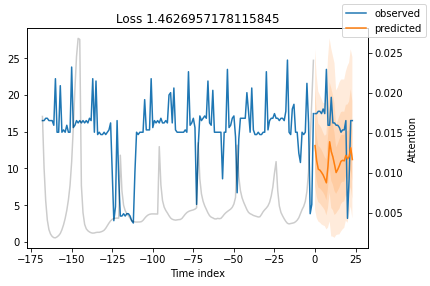

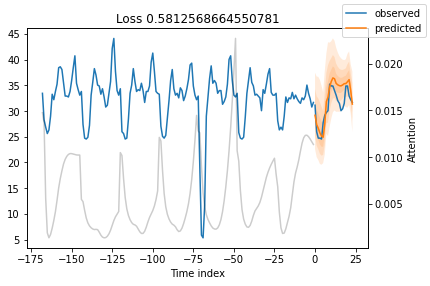

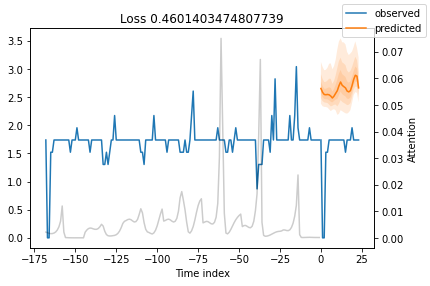

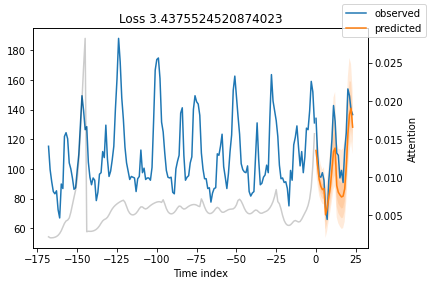

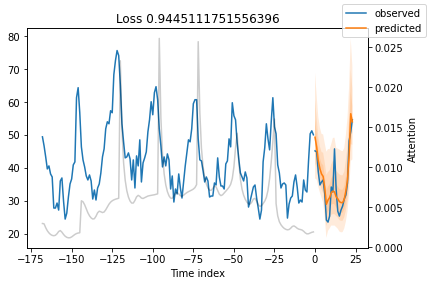

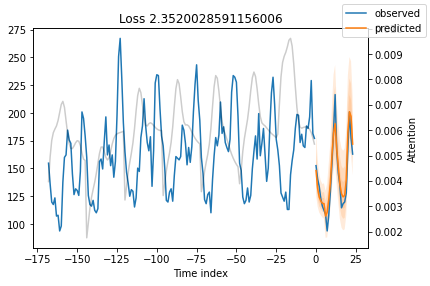

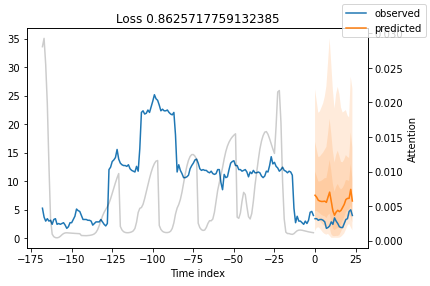

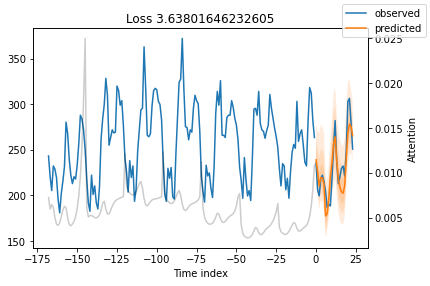

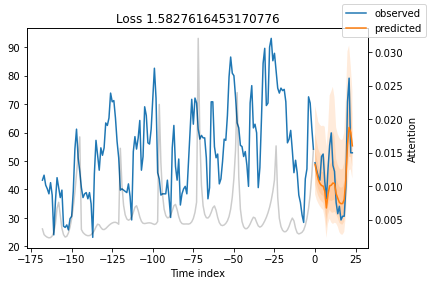

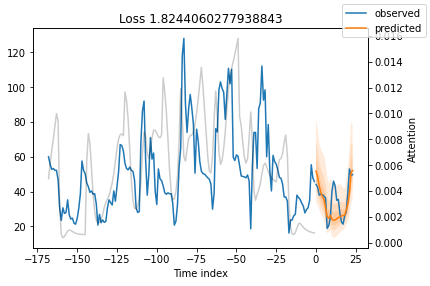

In [23]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
electricity_df.info()

In [ ]:
len(electricity_df['categorical_id'].unique())

In [ ]:
sum(electricity_df['id'] != electricity_df['categorical_id']

In [ ]:
electricity_df.info()

In [ ]:
electricity_df.head(5)